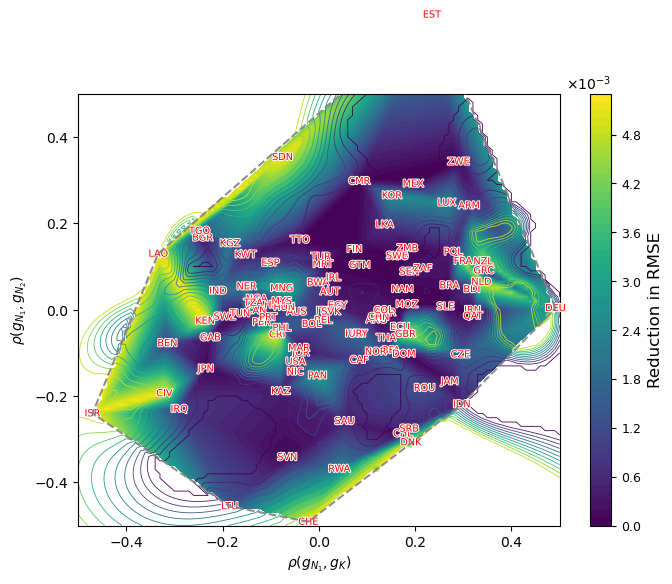

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.interpolate import griddata


# -----------------------------
# 1) Load data
# -----------------------------
csv_path = "/Users/xabajian/Documents/GitHub/ACF_NK_Measurement/simulations/bias_rmse.csv"
df = pd.read_csv(csv_path)

x = df["corr_N1_K_out"].to_numpy(dtype=float)
y = df["corr_N1_N2_out"].to_numpy(dtype=float)
# z = df["RMSE_reduction"].to_numpy(dtype=float)
z = df["RMSE_reduction_topcode"].to_numpy(dtype=float)

mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x, y, z = x[mask], y[mask], z[mask]

# -----------------------------
# 2) Even grid
# -----------------------------
grid_min, grid_max, step = -0.5, 0.5, 0.01
xi = np.arange(grid_min, grid_max + 1e-12, step)
yi = np.arange(grid_min, grid_max + 1e-12, step)
X, Y = np.meshgrid(xi, yi)

# -----------------------------
# 3) Linear interpolation for inside convex hull, RBF for extrapolation, floor at zero
# -----------------------------
from scipy.interpolate import griddata, Rbf
from scipy.spatial import cKDTree
import numpy as np

# --- 1) Linear interpolation (inside hull)
Z_linear = griddata((x, y), z, (X, Y), method="linear")

# --- 2) Smooth RBF surface (everywhere)
rbf = Rbf(x, y, z, function="multiquadric", smooth=1e-4)
Z_rbf = rbf(X, Y)

# --- 3) Distance to nearest observed point
tree = cKDTree(np.c_[x, y])
d, _ = tree.query(np.c_[X.ravel(), Y.ravel()], k=1)
d = d.reshape(X.shape)

# --- 4) Smooth blending weight
d0 = 0.10   # tune this (0.06–0.15 works well in your scale)
w = np.exp(-(d / d0)**2)

# --- 5) Blend: trust linear near data, RBF far away
Z = np.where(
    np.isnan(Z_linear),
    Z_rbf,
    w * Z_linear + (1 - w) * Z_rbf
)

# --- 6) Impose floor at zero and ceiling at in-sample max
Z = np.clip(Z, 0, np.max(z))


# -----------------------------
# 5) Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(7, 6))



# cf = ax.contourf(X, Y, Z, levels=60)
cf = ax.contourf(X, Y, Z_linear, levels=60)
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label(r"Reduction in RMSE", fontsize=12)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)


# Force scientific notation
cbar.formatter = ticker.ScalarFormatter(useMathText=True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))  # always scientific

cbar.ax.tick_params(labelsize=9)

cbar.update_ticks()

ax.contour(X, Y, Z, levels=12, linewidths=0.6)
iso_codes = df.loc[mask, "country_string"].values

import matplotlib.patheffects as pe

for xi, yi, label in zip(x, y, iso_codes):
    ax.text(
        xi, yi, label,
        color="red", fontsize=7, ha="center", va="center",
        path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
    )

from scipy.spatial import ConvexHull
import numpy as np

# Compute convex hull of observed points
pts = np.c_[x, y]
hull = ConvexHull(pts)

# Get hull vertices in order and close the loop
hull_xy = pts[hull.vertices]
hull_xy = np.vstack([hull_xy, hull_xy[0]])

# Plot hull boundary
ax.plot(
    hull_xy[:, 0], hull_xy[:, 1],
    linestyle="--",
    linewidth=1.5,
    color="grey",
    alpha=0.9,
    zorder=5
)

ax.set_xlabel(r"$\rho(g_{N_1}, g_{K})$")
ax.set_ylabel(r"$\rho(g_{N_1}, g_{N_2})$")
ax.set_xlim(grid_min, grid_max)
ax.set_ylim(grid_min, grid_max)

plt.tight_layout()
plt.show()

# Optional save:
fig.savefig("rmse_reduction_contour_extrapolated.pdf")

# # -----------------------------
# # 5) Plot (3D surface)
# # -----------------------------
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3d)
# import matplotlib.patheffects as pe

# fig = plt.figure(figsize=(9, 7))
# ax = fig.add_subplot(111, projection="3d")

# # --- 3D surface
# surf = ax.plot_surface(
#     X, Y, Z,
#     rstride=1, cstride=1,
#     linewidth=0,
#     antialiased=True,
#     shade=True
# )

# # --- Colorbar (uses the surface mappable)
# cbar = fig.colorbar(surf, ax=ax, shrink=0.65, pad=0.08)
# cbar.set_label(r"Reduction in RMSE", fontsize=12)

# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((0, 0))  # always scientific
# cbar.formatter = formatter
# cbar.update_ticks()

# # --- Optional: project contours onto the "floor"
# zmin = float(np.nanmin(Z))
# ax.contour(
#     X, Y, Z,
#     levels=12,
#     zdir="z",
#     offset=zmin,
#     linewidths=0.8
# )

# # --- ISO labels placed at interpolated height
# #     (Use nearest gridpoint for simplicity + robustness)
# ix = np.clip(np.round((x - grid_min) / step).astype(int), 0, X.shape[1] - 1)
# iy = np.clip(np.round((y - grid_min) / step).astype(int), 0, Y.shape[0] - 1)
# z_at_pts = Z[iy, ix]

# iso_codes = df.loc[mask, "country_string"].values
# for xi_, yi_, zi_, label in zip(x, y, z_at_pts, iso_codes):
#     ax.text(
#         xi_, yi_, zi_, label,
#         color="red", fontsize=7, ha="center", va="center",
#         path_effects=[pe.withStroke(linewidth=2.0, foreground="white")]
#     )

# # --- Convex hull boundary projected on the floor (z = zmin)
# ax.plot(
#     hull_xy[:, 0], hull_xy[:, 1], np.full(hull_xy.shape[0], zmin),
#     linestyle="--", linewidth=1.8, color="grey", alpha=0.9
# )

# # --- Labels + limits
# ax.set_xlabel(r"$\rho(g_{N_1}, g_{K})$")
# ax.set_ylabel(r"$\rho(g_{N_1}, g_{N_2})$")
# ax.set_zlabel(r"Reduction in RMSE")

# ax.set_xlim(grid_min, grid_max)
# ax.set_ylim(grid_min, grid_max)

# # Give a nicer view angle
# ax.view_init(elev=25, azim=235)

# plt.tight_layout()
# plt.show()

# # Optional save:
# fig.savefig("rmse_reduction_surface_3d.pdf")